# 1️⃣ IMPORTS

In [1]:
import os, sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import numpy as np

from sklearn.model_selection import train_test_split
from collections import defaultdict
import random
from glob import glob
from pathlib import Path


print('✓ GPU is available.' if torch.cuda.is_available() else '⚠ Use CPU for this demo')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

✓ GPU is available.


# 2️⃣ MODEL DOWNLOAD / SETUP

In [5]:
cd perception_models

c:\Users\amirn\OneDrive\Рабочий стол\ViT_opti\ViT_optimization\perception_models


In [6]:
DISTILLATION_LR = 1e-4
DISTILLATION_EPOCHS = 20
BATCH_SIZE = 16
NUM_WORKERS = 0
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

from core.vision_encoder import pe
from core.vision_encoder import transforms

print("Загружаем модель-учителя PE-Core-L14-336...")
teacher_model = pe.CLIP.from_config("PE-Core-L14-336", pretrained=True)
teacher_model = teacher_model.to(device).float().eval()

print("Загружаем модель-студента PE-Core-T16-384...")
student_model = pe.CLIP.from_config("PE-Core-T16-384", pretrained=True)
student_model = student_model.to(device).float()

print("✓ Модели загружены успешно")

c:\Users\amirn\OneDrive\Рабочий стол\ViT_opti\ViT_optimization\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Загружаем модель-учителя PE-Core-L14-336...
Missing keys for loading model: []
Unexpected keys for loading model: []
Загружаем модель-студента PE-Core-T16-384...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
c:\Users\amirn\OneDrive\Рабочий стол\ViT_opti\ViT_optimization\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\amirn\.cache\huggingface\hub\models--facebook--PE-Core-T16-384. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to acti

Missing keys for loading model: []
Unexpected keys for loading model: []
✓ Модели загружены успешно


In [7]:
# ========================================================================
# Препроцессоры и размеры признаков
# ========================================================================
teacher_preprocessor = transforms.get_image_transform(teacher_model.image_size)
student_preprocessor = transforms.get_image_transform(student_model.image_size)

teacher_dim = teacher_model.visual.output_dim
student_dim = student_model.visual.output_dim

print(f"Размер изображения для учителя: {teacher_model.image_size}")
print(f"Размер изображения для студента: {student_model.image_size}")
print(f"Размерность признаков учителя: {teacher_dim}")
print(f"Размерность признаков студента: {student_dim}")

Размер изображения для учителя: 336
Размер изображения для студента: 384
Размерность признаков учителя: 1024
Размерность признаков студента: 512


# 3️⃣ DATASET PREPARATION

In [8]:
cd ../data

c:\Users\amirn\OneDrive\Рабочий стол\ViT_opti\ViT_optimization\data


In [9]:
# ========================================================================
# Загрузка датасета
# ========================================================================
ROOT_DIR = 'kvasir-dataset-v2'

print("Шаг 1: Поиск всех изображений и их меток...")
all_image_paths = glob(os.path.join(ROOT_DIR, '**', '*.jpg'), recursive=True)
print(f"Найдено {len(all_image_paths)} изображений.")

def extract_label_from_path(image_path):
    """Извлекает метку из пути к изображению (папка после ROOT_DIR)."""
    path_parts = Path(image_path).parts
    try:
        labeled_images_idx = path_parts.index(Path(ROOT_DIR).name)
        return path_parts[labeled_images_idx + 1]
    except (ValueError, IndexError):
        return None

image_to_path = {}
image_to_label = {}

for path in all_image_paths:
    image_id = os.path.splitext(os.path.basename(path))[0]
    label = extract_label_from_path(path)
    if label:
        image_to_path[image_id] = path
        image_to_label[image_id] = label

print(f"Обработано {len(image_to_label)} уникальных изображений с валидными метками.")

Шаг 1: Поиск всех изображений и их меток...
Найдено 8000 изображений.
Обработано 7999 уникальных изображений с валидными метками.


In [10]:
# ========================================================================
# Балансированное подмножество
# ========================================================================
print("Шаг 2: Создание сбалансированного подмножества...")

images_by_class = defaultdict(list)
for image_id, label in image_to_label.items():
    images_by_class[label].append(image_id)

images_per_class = 500
sampled_image_ids = []

for label, id_list in images_by_class.items():
    available = len(id_list)
    n_to_sample = min(images_per_class, available)
    if available < images_per_class:
        print(f"Предупреждение: Доступно только {available} изображений для '{label}'")
    sampled_ids = random.sample(id_list, n_to_sample)
    sampled_image_ids.extend(sampled_ids)

random.shuffle(sampled_image_ids)
print(f"Создано подмножество из {len(sampled_image_ids)} изображений для дистилляции")


Шаг 2: Создание сбалансированного подмножества...
Создано подмножество из 4000 изображений для дистилляции


In [11]:
# ========================================================================
# Разделение на train/val/test
# ========================================================================
print("Шаг 3: Разделение данных...")

sampled_labels = [image_to_label[img_id] for img_id in sampled_image_ids]

train_val_ids, test_ids = train_test_split(
    sampled_image_ids,
    test_size=0.20,
    stratify=sampled_labels,
    random_state=SEED
)

train_val_labels = [image_to_label[img_id] for img_id in train_val_ids]
train_ids, val_ids = train_test_split(
    train_val_ids,
    test_size=0.20,
    stratify=train_val_labels,
    random_state=SEED
)

print(f"Размеры наборов данных:")
print(f"  - Тренировочный (train): {len(train_ids)}")
print(f"  - Валидационный (val): {len(val_ids)}")
print(f"  - Тестовый: {len(test_ids)}")

classes = sorted(list(set(image_to_label.values())))
label_to_idx = {label: i for i, label in enumerate(classes)}
idx_to_label = {i: label for label, i in label_to_idx.items()}

print(f"Найдено {len(classes)} классов: {classes}")

Шаг 3: Разделение данных...
Размеры наборов данных:
  - Тренировочный (train): 2560
  - Валидационный (val): 640
  - Тестовый: 800
Найдено 8 классов: ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']


In [12]:
# ========================================================================
# Dataset
# ========================================================================
class DistillationDataset(Dataset):
    def __init__(self, image_ids, image_to_path_map, image_to_label_map, 
                 label_to_idx_map, teacher_transform, student_transform):
        self.image_ids = image_ids
        self.image_to_path = image_to_path_map
        self.image_to_label = image_to_label_map
        self.label_to_idx = label_to_idx_map
        self.teacher_transform = teacher_transform
        self.student_transform = student_transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = self.image_to_path[image_id]
        label = self.image_to_label[image_id]
        label_idx = self.label_to_idx[label]

        img = Image.open(image_path).convert('RGB')

        teacher_input = self.teacher_transform(img)  # tensor
        student_input = self.student_transform(img)  # tensor

        return teacher_input, student_input, torch.tensor(label_idx, dtype=torch.long)

train_dataset = DistillationDataset(train_ids, image_to_path, image_to_label, label_to_idx,
                                    teacher_preprocessor, student_preprocessor)
val_dataset = DistillationDataset(val_ids, image_to_path, image_to_label, label_to_idx,
                                  teacher_preprocessor, student_preprocessor)
test_dataset = DistillationDataset(test_ids, image_to_path, image_to_label, label_to_idx,
                                   teacher_preprocessor, student_preprocessor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"✓ Созданы датасеты:")
print(f"  - Train: {len(train_dataset)} изображений")
print(f"  - Val: {len(val_dataset)} изображений")
print(f"  - Test: {len(test_dataset)} изображений")

✓ Созданы датасеты:
  - Train: 2560 изображений
  - Val: 640 изображений
  - Test: 800 изображений


# 4️⃣ MODEL PREPARATION

In [13]:
# ========================================================================
# Классификационная голова и проекция
# ========================================================================
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, num_classes)
        )
    def forward(self, x):
        return self.classifier(x)

class ProjectionHead(nn.Module):
    def __init__(self, student_dim, teacher_dim):
        super().__init__()
        self.projection = nn.Linear(student_dim, teacher_dim)
    def forward(self, x):
        return self.projection(x)

num_classes = len(classes)
classification_head = ClassificationHead(student_dim, num_classes).to(device)
projection_head = ProjectionHead(student_dim, teacher_dim).to(device)

print(f"✓ Создан классификатор: {student_dim} -> {num_classes} классов")
print(f"  Параметров в классификаторе: {sum(p.numel() for p in classification_head.parameters()):,}")
print(f"✓ Создан проекционный слой: {student_dim} -> {teacher_dim}")
print(f"  Параметров в проекции: {sum(p.numel() for p in projection_head.parameters()):,}")

# ========================================================================
# Функция потерь
# ========================================================================
class ImprovedDistillationLoss(nn.Module):
    def __init__(self, temperature=4.0, alpha=0.5):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss()
    def forward(self, student_features_projected, teacher_features, student_logits, labels):
        student_norm = F.normalize(student_features_projected, p=2, dim=-1)
        teacher_norm = F.normalize(teacher_features, p=2, dim=-1)
        cosine_sim = F.cosine_similarity(student_norm, teacher_norm, dim=-1)  # (batch,)
        feature_loss = (1.0 - cosine_sim).mean()
        classification_loss = self.ce_loss(student_logits, labels)
        total_loss = self.alpha * feature_loss + (1.0 - self.alpha) * classification_loss
        return total_loss, feature_loss, classification_loss

distillation_criterion = ImprovedDistillationLoss(temperature=4.0, alpha=0.5)
print("✓ Инициализирована функция потерь с проекцией")

# ========================================================================
# Оптимизатор
# ========================================================================
trainable_params = list(student_model.parameters()) + list(classification_head.parameters()) + list(projection_head.parameters())
optimizer = torch.optim.AdamW(trainable_params, lr=DISTILLATION_LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=DISTILLATION_EPOCHS)

print("✓ Настройки обучения обновлены")
print(f"  Всего обучаемых параметров: {sum(p.numel() for p in trainable_params):,}")

✓ Создан классификатор: 512 -> 8 классов
  Параметров в классификаторе: 4,104
✓ Создан проекционный слой: 512 -> 1024
  Параметров в проекции: 525,312
✓ Инициализирована функция потерь с проекцией
✓ Настройки обучения обновлены
  Всего обучаемых параметров: 70,075,017


In [14]:
# ========================================================================
# Валидация
# ========================================================================
def validate(student, classifier, projection, val_loader, criterion, device):
    student.eval()
    classifier.eval()
    projection.eval()

    total_loss = 0.0
    total_feature_loss = 0.0
    total_cls_loss = 0.0
    correct = 0
    total = 0
    n_batches = 0

    with torch.no_grad():
        for teacher_inputs, student_inputs, labels in val_loader:
            teacher_inputs = teacher_inputs.to(device)
            student_inputs = student_inputs.to(device)
            labels = labels.to(device)

            # teacher_features получаем от учителя (on device)
            teacher_features = teacher_model.encode_image(teacher_inputs)

            # student features
            student_features = student.encode_image(student_inputs)

            # проекция и логиты
            student_features_projected = projection(student_features)
            logits = classifier(student_features)

            loss, feature_loss, cls_loss = criterion(student_features_projected, teacher_features, logits, labels)

            total_loss += loss.item()
            total_feature_loss += feature_loss.item()
            total_cls_loss += cls_loss.item()

            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            n_batches += 1

    if n_batches == 0:
        return 0.0, 0.0, 0.0, 0.0

    avg_loss = total_loss / n_batches
    avg_feature_loss = total_feature_loss / n_batches
    avg_cls_loss = total_cls_loss / n_batches
    accuracy = 100.0 * correct / total if total > 0 else 0.0

    return avg_loss, avg_feature_loss, avg_cls_loss, accuracy

print("✓ Функция валидации готова")


✓ Функция валидации готова


# 5️⃣ TRAINING LOOP

In [16]:
ls

 ��� � ���ன�⢥ C �� ����� ��⪨.
 ��਩�� ����� ⮬�: AA35-AB91

 ����ন��� ����� c:\Users\amirn\OneDrive\����稩 �⮫\ViT_opti\ViT_optimization\data

23.10.2025  23:38    <DIR>          .
23.10.2025  23:20    <DIR>          ..
23.10.2025  15:14    <DIR>          kvasir-dataset-v2
               0 䠩���              0 ����
               3 �����  397�030�596�608 ���� ᢮�����


In [15]:
cd data

[WinError 2] Не удается найти указанный файл: 'data'
c:\Users\amirn\OneDrive\Рабочий стол\ViT_opti\ViT_optimization\data


In [17]:
# ========================================================================
# Основной цикл обучения
# ========================================================================
print("\n" + "="*80)
print("НАЧАЛО ОБУЧЕНИЯ С ДИСТИЛЛЯЦИЕЙ")
print("="*80 + "\n")

best_val_accuracy = 0.0
best_epoch = 0
history = {
    'train_loss': [], 'train_feature_loss': [], 'train_cls_loss': [],
    'val_loss': [], 'val_feature_loss': [], 'val_cls_loss': [],
    'val_accuracy': []
}

for epoch in range(1, DISTILLATION_EPOCHS + 1):
    student_model.train()
    classification_head.train()
    projection_head.train()

    train_loss = 0.0
    train_feature_loss = 0.0
    train_cls_loss = 0.0
    num_batches = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{DISTILLATION_EPOCHS}")

    for teacher_inputs, student_inputs, labels in progress_bar:
        teacher_inputs = teacher_inputs.to(device)
        student_inputs = student_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.no_grad():
            teacher_features = teacher_model.encode_image(teacher_inputs)

        student_features = student_model.encode_image(student_inputs)

        student_features_projected = projection_head(student_features)
        logits = classification_head(student_features)

        loss, feature_loss, cls_loss = distillation_criterion(
            student_features_projected, teacher_features, logits, labels
        )

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_feature_loss += feature_loss.item()
        train_cls_loss += cls_loss.item()
        num_batches += 1

        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Feat': f'{feature_loss.item():.4f}',
            'Cls': f'{cls_loss.item():.4f}'
        })

    avg_train_loss = train_loss / max(1, num_batches)
    avg_train_feature_loss = train_feature_loss / max(1, num_batches)
    avg_train_cls_loss = train_cls_loss / max(1, num_batches)

    # Валидация
    val_loss, val_feature_loss, val_cls_loss, val_accuracy = validate(
        student_model, classification_head, projection_head, val_loader,
        distillation_criterion, device
    )

    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(avg_train_loss)
    history['train_feature_loss'].append(avg_train_feature_loss)
    history['train_cls_loss'].append(avg_train_cls_loss)
    history['val_loss'].append(val_loss)
    history['val_feature_loss'].append(val_feature_loss)
    history['val_cls_loss'].append(val_cls_loss)
    history['val_accuracy'].append(val_accuracy)

    # Логи
    print(f"\nEpoch {epoch}/{DISTILLATION_EPOCHS}:")
    print(f"  Train Loss: {avg_train_loss:.4f} (Feature: {avg_train_feature_loss:.4f}, Cls: {avg_train_cls_loss:.4f})")
    print(f"  Val Loss:   {val_loss:.4f} (Feature: {val_feature_loss:.4f}, Cls: {val_cls_loss:.4f})")
    print(f"  Val Accuracy: {val_accuracy:.2f}%")
    print(f"  Learning Rate: {current_lr:.6f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        best_checkpoint = {
            'epoch': epoch,
            'student_state_dict': student_model.state_dict(),
            'classifier_state_dict': classification_head.state_dict(),
            'projection_state_dict': projection_head.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_accuracy,
            'val_loss': val_loss,
            'config': "PE-Core-S16-384",
            'classes': classes,
            'label_to_idx': label_to_idx
        }
        torch.save(best_checkpoint, '../model_weights/student_best_model.pth')
        print(f"  ✓ Сохранена лучшая модель с accuracy {val_accuracy:.2f}%")

    if epoch % 5 == 0:
        checkpoint = {
            'epoch': epoch,
            'student_state_dict': student_model.state_dict(),
            'classifier_state_dict': classification_head.state_dict(),
            'projection_state_dict': projection_head.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_accuracy': val_accuracy,
            'history': history
        }
        torch.save(checkpoint, f'../model_weights/student_checkpoint_epoch_{epoch}.pth')
        print(f"  ✓ Сохранен чекпоинт эпохи {epoch}")

    print("-" * 80)

print("\n" + "="*80)
print("ОБУЧЕНИЕ ЗАВЕРШЕНО!")
print("="*80)
print(f"Лучшая валидационная точность: {best_val_accuracy:.2f}% (эпоха {best_epoch})")


НАЧАЛО ОБУЧЕНИЯ С ДИСТИЛЛЯЦИЕЙ



Epoch 1/20: 100%|██████████| 160/160 [02:43<00:00,  1.02s/it, Loss=0.4659, Feat=0.0583, Cls=0.8736]



Epoch 1/20:
  Train Loss: 0.6506 (Feature: 0.1481, Cls: 1.1531)
  Val Loss:   0.4285 (Feature: 0.0511, Cls: 0.8060)
  Val Accuracy: 57.34%
  Learning Rate: 0.000099
  ✓ Сохранена лучшая модель с accuracy 57.34%
--------------------------------------------------------------------------------


Epoch 2/20: 100%|██████████| 160/160 [02:20<00:00,  1.14it/s, Loss=0.3713, Feat=0.0483, Cls=0.6944]



Epoch 2/20:
  Train Loss: 0.4533 (Feature: 0.0493, Cls: 0.8574)
  Val Loss:   0.4403 (Feature: 0.0473, Cls: 0.8332)
  Val Accuracy: 57.19%
  Learning Rate: 0.000098
--------------------------------------------------------------------------------


Epoch 3/20: 100%|██████████| 160/160 [02:20<00:00,  1.14it/s, Loss=0.6229, Feat=0.0446, Cls=1.2012]



Epoch 3/20:
  Train Loss: 0.3923 (Feature: 0.0448, Cls: 0.7399)
  Val Loss:   0.4542 (Feature: 0.0436, Cls: 0.8648)
  Val Accuracy: 58.44%
  Learning Rate: 0.000095
  ✓ Сохранена лучшая модель с accuracy 58.44%
--------------------------------------------------------------------------------


Epoch 4/20: 100%|██████████| 160/160 [02:17<00:00,  1.17it/s, Loss=0.2950, Feat=0.0364, Cls=0.5537]



Epoch 4/20:
  Train Loss: 0.3902 (Feature: 0.0440, Cls: 0.7364)
  Val Loss:   0.3777 (Feature: 0.0414, Cls: 0.7139)
  Val Accuracy: 64.84%
  Learning Rate: 0.000090
  ✓ Сохранена лучшая модель с accuracy 64.84%
--------------------------------------------------------------------------------


Epoch 5/20: 100%|██████████| 160/160 [02:16<00:00,  1.17it/s, Loss=0.3201, Feat=0.0429, Cls=0.5974]



Epoch 5/20:
  Train Loss: 0.3556 (Feature: 0.0426, Cls: 0.6686)
  Val Loss:   0.3617 (Feature: 0.0415, Cls: 0.6820)
  Val Accuracy: 66.41%
  Learning Rate: 0.000085
  ✓ Сохранена лучшая модель с accuracy 66.41%
  ✓ Сохранен чекпоинт эпохи 5
--------------------------------------------------------------------------------


Epoch 6/20: 100%|██████████| 160/160 [02:17<00:00,  1.17it/s, Loss=0.4282, Feat=0.0394, Cls=0.8169]



Epoch 6/20:
  Train Loss: 0.3267 (Feature: 0.0428, Cls: 0.6107)
  Val Loss:   0.4343 (Feature: 0.0456, Cls: 0.8231)
  Val Accuracy: 62.34%
  Learning Rate: 0.000079
--------------------------------------------------------------------------------


Epoch 7/20: 100%|██████████| 160/160 [02:17<00:00,  1.16it/s, Loss=0.4074, Feat=0.0317, Cls=0.7831]



Epoch 7/20:
  Train Loss: 0.3216 (Feature: 0.0415, Cls: 0.6018)
  Val Loss:   0.3287 (Feature: 0.0394, Cls: 0.6181)
  Val Accuracy: 72.81%
  Learning Rate: 0.000073
  ✓ Сохранена лучшая модель с accuracy 72.81%
--------------------------------------------------------------------------------


Epoch 8/20: 100%|██████████| 160/160 [02:17<00:00,  1.17it/s, Loss=0.2503, Feat=0.0412, Cls=0.4593]



Epoch 8/20:
  Train Loss: 0.2866 (Feature: 0.0404, Cls: 0.5329)
  Val Loss:   0.2922 (Feature: 0.0393, Cls: 0.5452)
  Val Accuracy: 75.16%
  Learning Rate: 0.000065
  ✓ Сохранена лучшая модель с accuracy 75.16%
--------------------------------------------------------------------------------


Epoch 9/20: 100%|██████████| 160/160 [02:20<00:00,  1.14it/s, Loss=0.2315, Feat=0.0370, Cls=0.4261]



Epoch 9/20:
  Train Loss: 0.2508 (Feature: 0.0397, Cls: 0.4619)
  Val Loss:   0.3190 (Feature: 0.0391, Cls: 0.5989)
  Val Accuracy: 74.38%
  Learning Rate: 0.000058
--------------------------------------------------------------------------------


Epoch 10/20: 100%|██████████| 160/160 [02:21<00:00,  1.13it/s, Loss=0.1475, Feat=0.0321, Cls=0.2630]



Epoch 10/20:
  Train Loss: 0.2172 (Feature: 0.0387, Cls: 0.3958)
  Val Loss:   0.2635 (Feature: 0.0374, Cls: 0.4896)
  Val Accuracy: 79.38%
  Learning Rate: 0.000050
  ✓ Сохранена лучшая модель с accuracy 79.38%
  ✓ Сохранен чекпоинт эпохи 10
--------------------------------------------------------------------------------


Epoch 11/20: 100%|██████████| 160/160 [02:20<00:00,  1.14it/s, Loss=0.1449, Feat=0.0389, Cls=0.2508]



Epoch 11/20:
  Train Loss: 0.1836 (Feature: 0.0382, Cls: 0.3289)
  Val Loss:   0.2995 (Feature: 0.0383, Cls: 0.5607)
  Val Accuracy: 77.50%
  Learning Rate: 0.000042
--------------------------------------------------------------------------------


Epoch 12/20: 100%|██████████| 160/160 [02:19<00:00,  1.14it/s, Loss=0.1790, Feat=0.0347, Cls=0.3232]



Epoch 12/20:
  Train Loss: 0.1402 (Feature: 0.0382, Cls: 0.2421)
  Val Loss:   0.3204 (Feature: 0.0378, Cls: 0.6031)
  Val Accuracy: 77.97%
  Learning Rate: 0.000035
--------------------------------------------------------------------------------


Epoch 13/20: 100%|██████████| 160/160 [02:21<00:00,  1.13it/s, Loss=0.1022, Feat=0.0360, Cls=0.1684]



Epoch 13/20:
  Train Loss: 0.1171 (Feature: 0.0377, Cls: 0.1966)
  Val Loss:   0.3448 (Feature: 0.0374, Cls: 0.6521)
  Val Accuracy: 76.72%
  Learning Rate: 0.000027
--------------------------------------------------------------------------------


Epoch 14/20: 100%|██████████| 160/160 [02:20<00:00,  1.14it/s, Loss=0.0231, Feat=0.0320, Cls=0.0143]



Epoch 14/20:
  Train Loss: 0.0775 (Feature: 0.0372, Cls: 0.1178)
  Val Loss:   0.3736 (Feature: 0.0373, Cls: 0.7100)
  Val Accuracy: 78.12%
  Learning Rate: 0.000021
--------------------------------------------------------------------------------


Epoch 15/20: 100%|██████████| 160/160 [02:45<00:00,  1.03s/it, Loss=0.0370, Feat=0.0430, Cls=0.0310]



Epoch 15/20:
  Train Loss: 0.0508 (Feature: 0.0371, Cls: 0.0645)
  Val Loss:   0.3709 (Feature: 0.0370, Cls: 0.7049)
  Val Accuracy: 79.84%
  Learning Rate: 0.000015
  ✓ Сохранена лучшая модель с accuracy 79.84%
  ✓ Сохранен чекпоинт эпохи 15
--------------------------------------------------------------------------------


Epoch 16/20: 100%|██████████| 160/160 [02:52<00:00,  1.08s/it, Loss=0.0222, Feat=0.0376, Cls=0.0068]



Epoch 16/20:
  Train Loss: 0.0395 (Feature: 0.0368, Cls: 0.0422)
  Val Loss:   0.3661 (Feature: 0.0368, Cls: 0.6955)
  Val Accuracy: 79.84%
  Learning Rate: 0.000010
--------------------------------------------------------------------------------


Epoch 17/20: 100%|██████████| 160/160 [02:36<00:00,  1.03it/s, Loss=0.0179, Feat=0.0326, Cls=0.0032]



Epoch 17/20:
  Train Loss: 0.0284 (Feature: 0.0367, Cls: 0.0202)
  Val Loss:   0.3978 (Feature: 0.0369, Cls: 0.7587)
  Val Accuracy: 79.69%
  Learning Rate: 0.000005
--------------------------------------------------------------------------------


Epoch 18/20: 100%|██████████| 160/160 [02:43<00:00,  1.02s/it, Loss=0.0227, Feat=0.0366, Cls=0.0087]



Epoch 18/20:
  Train Loss: 0.0236 (Feature: 0.0366, Cls: 0.0106)
  Val Loss:   0.4133 (Feature: 0.0369, Cls: 0.7897)
  Val Accuracy: 79.38%
  Learning Rate: 0.000002
--------------------------------------------------------------------------------


Epoch 19/20: 100%|██████████| 160/160 [02:50<00:00,  1.07s/it, Loss=0.0213, Feat=0.0364, Cls=0.0062]



Epoch 19/20:
  Train Loss: 0.0222 (Feature: 0.0365, Cls: 0.0078)
  Val Loss:   0.4187 (Feature: 0.0369, Cls: 0.8005)
  Val Accuracy: 79.22%
  Learning Rate: 0.000001
--------------------------------------------------------------------------------


Epoch 20/20: 100%|██████████| 160/160 [02:50<00:00,  1.06s/it, Loss=0.0201, Feat=0.0342, Cls=0.0060]



Epoch 20/20:
  Train Loss: 0.0216 (Feature: 0.0365, Cls: 0.0067)
  Val Loss:   0.4206 (Feature: 0.0369, Cls: 0.8044)
  Val Accuracy: 79.22%
  Learning Rate: 0.000000
  ✓ Сохранен чекпоинт эпохи 20
--------------------------------------------------------------------------------

ОБУЧЕНИЕ ЗАВЕРШЕНО!
Лучшая валидационная точность: 79.84% (эпоха 15)


# 6️⃣ EVALUATION/TESTING

In [18]:
# --- Тестирование финальной модели ---
print("\n" + "="*80)
print("ТЕСТИРОВАНИЕ НА TEST SET")
print("="*80 + "\n")

if len(test_dataset) == 0:
    raise ValueError("Тестовый датасет пуст! Проверьте test_ids и Dataset.")

student_model.eval()
classification_head.eval()
projection = nn.Linear(student_dim, teacher_dim).cuda()  

test_correct = 0
test_total = 0
class_correct = defaultdict(int)
class_total = defaultdict(int)
similarities = []
mse_distances = []

with torch.no_grad():
    for _, student_inputs, labels in tqdm(test_loader, desc="Тестирование", leave=False):
        student_inputs = student_inputs.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)

        student_features = student_model.encode_image(student_inputs)
        student_features_proj = projection(student_features)

        logits = classification_head(student_features)
        _, predicted = torch.max(logits, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        for i in range(labels.size(0)):
            label = labels[i].item()
            class_name = idx_to_label[label]
            if predicted[i] == labels[i]:
                class_correct[class_name] += 1

        teacher_features = teacher_model.encode_image(student_inputs)  
        teacher_norm = F.normalize(teacher_features, p=2, dim=-1)
        student_norm = F.normalize(student_features_proj, p=2, dim=-1)

        cosine_sim = F.cosine_similarity(teacher_norm, student_norm, dim=-1)
        similarities.extend(cosine_sim.cpu().tolist())

        mse_batch = F.mse_loss(student_norm, teacher_norm, reduction="none").mean(dim=1)
        mse_distances.extend(mse_batch.cpu().tolist())

if test_total > 0:
    test_accuracy = 100 * test_correct / test_total
else:
    test_accuracy = 0.0

avg_similarity = np.mean(similarities) if similarities else 0.0
avg_mse = np.mean(mse_distances) if mse_distances else 0.0

print(f"\nРезультаты на тестовом наборе:")
print(f"  Test Accuracy: {test_accuracy:.2f}%")
print(f"  Средняя косинусная близость признаков: {avg_similarity:.4f}")
print(f"  Среднее MSE расстояние признаков: {avg_mse:.4f}")

print(f"\nAccuracy по классам:")
for class_name in sorted(class_total.keys()):
    class_acc = 100 * class_correct[class_name] / class_total[class_name] if class_total[class_name] > 0 else 0.0
    print(f"  {class_name}: {class_acc:.2f}% ({class_correct[class_name]}/{class_total[class_name]})")



ТЕСТИРОВАНИЕ НА TEST SET




Результаты на тестовом наборе:
  Test Accuracy: 79.75%
  Средняя косинусная близость признаков: 0.0239
  Среднее MSE расстояние признаков: 0.0019

Accuracy по классам:


# 7️⃣ SAVE / EXPORT RESULTS

In [22]:
cd ..

c:\Users\amirn\OneDrive\Рабочий стол\ViT_opti\ViT_optimization


In [23]:
final_checkpoint = {
    "student_state_dict": student_model.state_dict(),
    "classifier_state_dict": classification_head.state_dict(),
    "config": "PE-Core-S16-384",
    "classes": classes,
    "label_to_idx": label_to_idx,
    "idx_to_label": idx_to_label,
    "history": history,
    "teacher_dim": teacher_dim,
    "student_dim": student_dim,
    "num_classes": num_classes
}

torch.save(final_checkpoint, "model_weights/student_distilled_final.pth")
print("✅ Финальная модель сохранена: model_weights/student_distilled_final.pth")

# ============================================================================
# Сравнение моделей
# ============================================================================
print("\n" + "=" * 80)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("=" * 80)

teacher_params = sum(p.numel() for p in teacher_model.parameters())
student_params = sum(p.numel() for p in student_model.parameters())
classifier_params = sum(p.numel() for p in classification_head.parameters())

teacher_size = teacher_params * 4 / (1024 ** 2)  # MB (float32)
student_size = (student_params + classifier_params) * 4 / (1024 ** 2)  # MB

print(f"👩‍🏫 Учитель (PE-Core-L14-336):")
print(f"  • Параметры: {teacher_params:,}")
print(f"  • Размер: {teacher_size:.1f} MB")
print(f"  • Feature dim: {teacher_dim}")

print(f"\n👨‍🎓 Студент (PE-Core-S16-384 + Classifier):")
print(f"  • Параметры: {student_params + classifier_params:,}")
print(f"  • Размер: {student_size:.1f} MB")
print(f"  • Feature dim: {student_dim}")

print(f"\n📉 Сжатие: {teacher_size / student_size:.1f}x")
print(f"📦 Снижение параметров: {teacher_params / (student_params + classifier_params):.1f}x")


✅ Финальная модель сохранена: model_weights/student_distilled_final.pth

СРАВНЕНИЕ МОДЕЛЕЙ
👩‍🏫 Учитель (PE-Core-L14-336):
  • Параметры: 671,137,793
  • Размер: 2560.2 MB
  • Feature dim: 1024

👨‍🎓 Студент (PE-Core-S16-384 + Classifier):
  • Параметры: 69,549,705
  • Размер: 265.3 MB
  • Feature dim: 512

📉 Сжатие: 9.6x
📦 Снижение параметров: 9.6x


#  8️⃣RESULTS & VISUALIZATION


📈 График обучения сохранен: feature_t_training_history.png


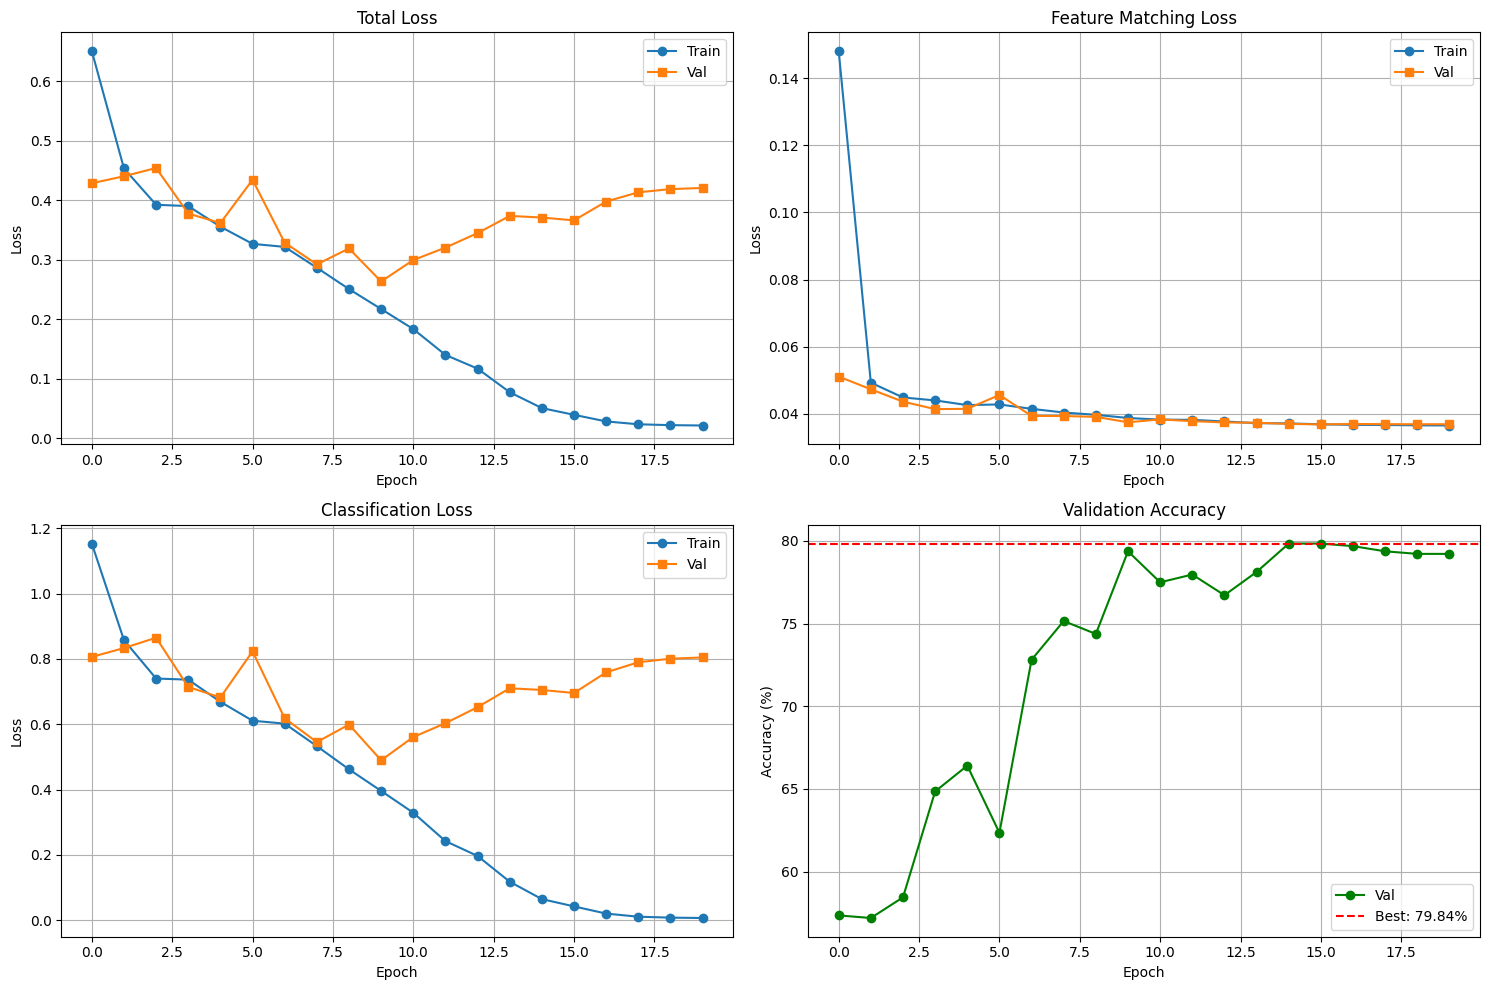


🎉 ДИСТИЛЛЯЦИЯ ЗАВЕРШЕНА УСПЕШНО!

Финальные результаты:
  • Лучшая валидационная точность: 79.84%
  • Тестовая точность: 79.75%
  • Сжатие модели: 9.6x
  • Качество признаков (cosine similarity): 0.0239


In [26]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# --- Total Loss ---
axes[0, 0].plot(history["train_loss"], label="Train", marker="o")
axes[0, 0].plot(history["val_loss"], label="Val", marker="s")
axes[0, 0].set_title("Total Loss")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()
axes[0, 0].grid(True)

# --- Feature Loss ---
axes[0, 1].plot(history["train_feature_loss"], label="Train", marker="o")
axes[0, 1].plot(history["val_feature_loss"], label="Val", marker="s")
axes[0, 1].set_title("Feature Matching Loss")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()
axes[0, 1].grid(True)

# --- Classification Loss ---
axes[1, 0].plot(history["train_cls_loss"], label="Train", marker="o")
axes[1, 0].plot(history["val_cls_loss"], label="Val", marker="s")
axes[1, 0].set_title("Classification Loss")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Loss")
axes[1, 0].legend()
axes[1, 0].grid(True)

# --- Validation Accuracy ---
axes[1, 1].plot(history["val_accuracy"], label="Val", marker="o", color="green")
axes[1, 1].axhline(y=best_val_accuracy, color="red", linestyle="--",
                   label=f"Best: {best_val_accuracy:.2f}%")
axes[1, 1].set_title("Validation Accuracy")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Accuracy (%)")
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig("images/feature_t_training_history.png", dpi=150, bbox_inches="tight")
print("\n📈 График обучения сохранен: feature_t_training_history.png")
plt.show()

print("\n" + "=" * 80)
print("🎉 ДИСТИЛЛЯЦИЯ ЗАВЕРШЕНА УСПЕШНО!")
print("=" * 80)
print(f"\nФинальные результаты:")
print(f"  • Лучшая валидационная точность: {best_val_accuracy:.2f}%")
print(f"  • Тестовая точность: {test_accuracy:.2f}%")
print(f"  • Сжатие модели: {teacher_size / student_size:.1f}x")
print(f"  • Качество признаков (cosine similarity): {avg_similarity:.4f}")